In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
from tqdm import tqdm
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import scipy.stats as stats
import statsmodels.stats.multicomp as mc
from scipy.stats import normaltest
from scipy.stats import shapiro
import scikit_posthocs as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols
import math
import os
from matplotlib.lines import Line2D

# CMA aging Atlas: All tissues analysis
Data downloaded from Tabula muris senis project. All tissues data, Smart-seq2 assay in .h5ad format was used for further analysis. This is an update analysis performed on 04132023. The difference is that here **ALL TISSUES** will be considered while in the previous analysis **ONLY INCLUDED TISSUES** in the paper, but **ALL** at the same time, were included.

In [2]:
# Creating folder for outputs
os.makedirs('../Khawaja_et_al_outputs/newAllTis')

## Importing and preprocessing data

In [3]:
# Import h5ad file in scanpy. 
adata = sc.read_h5ad('../Exp. 2_Tabula muris/Files/TM_all_smartseq.h5ad')

# Normalize as CPM (counts per million)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e6)

# Transforming CPM into log form
sc.pp.log1p(adata)

## CMA score calculation

In [6]:
# Load matrix file with weight and direction 
model_matrix = pd.read_excel('../Exp. 2_Tabula muris/activation_model.xlsx')

# Removing EEF1A1 and RAC1 genes because they don't appear in the adata
model_matrix = model_matrix.drop([6, 8], axis=0).reset_index()

# Finding CMA network genes in the dataset
cma_network = adata[:, model_matrix["Ensembl_ms"]]

# Calculating the Zs scores
cma_data_zs = cma_network.copy().X.todense().T

for i in tqdm(np.arange(cma_data_zs.shape[0])):
    
    µ = np.mean(cma_data_zs[i, :])
    sd = np.std(cma_data_zs[i, :])
    
    cma_data_zs[i, :] = (cma_data_zs[i, :] - µ)/sd
    
# Generating a copy of adata.obs to work with
barcode = adata.obs

# New column in barcode (aka adata.obs) with the CMA scores for each cell detected
for i,j in tqdm(enumerate(barcode.index)):
        
    cell_matrix = model_matrix.copy()

    for g in cell_matrix.index:

        cell_matrix.loc[g, 'gene_count'] = cma_data_zs[g, i]

    cell_matrix['gene_score'] = cell_matrix['gene_count'] * cell_matrix['Direction'] * cell_matrix['Weight']
    score = cell_matrix['gene_score'].sum()/np.sum(cell_matrix['Weight'])

    barcode.loc[j, 'score'] = score   
    

100%|██████████| 16/16 [00:00<00:00, 71.45it/s]
110824it [07:09, 258.21it/s]


## CMA net score/cell type (fold over whole tissue)

In [7]:
# Generating new ages
for j in tqdm(barcode.index):    
    if barcode.loc[j, 'age'] == '3m':        
        barcode.loc[j, 'new_age'] = '3m'

    elif barcode.loc[j, 'age'] == '18m':                
        barcode.loc[j, 'new_age'] = '18-24m'

    elif barcode.loc[j, 'age'] == '24m': 
        barcode.loc[j, 'new_age'] = '18-24m'
barcode.head()

100%|██████████| 110824/110824 [00:20<00:00, 5307.23it/s]


,FACS.selection,age,cell,free_annotation,method,donor_id,subtissue,n_genes,n_counts,louvain,...,cell_type,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,score,new_age
index,,,,,,,,,,,,,,,,,,,,,
A10_B000497_B009023_S10.mm10-plus-0-0,Multiple,18m,A10_B000497,nan,facs,18_53_M,nan,2706,4855.988770,10,...,keratinocyte stem cell,Smart-seq2,normal,Mus musculus,male,skin of body,na,18 month-old stage,0.840635,18-24m
A10_B000756_B007446_S10.mm10-plus-0-0,Viable,18m,A10_B000756,pancreatic B cell,facs,18_45_M,Endocrine,3212,6891.192383,31,...,type B pancreatic cell,Smart-seq2,normal,Mus musculus,male,pancreas,na,18 month-old stage,-0.152484,18-24m
A10_B000802_B009022_S10.mm10-plus-0-0,Multiple,18m,A10_B000802,outer bulge,facs,18_47_F,Skin Anagen,2243,4707.827148,10,...,keratinocyte stem cell,Smart-seq2,normal,Mus musculus,female,skin of body,na,18 month-old stage,-0.273630,18-24m
A10_B000927_B007456_S10.mm10-plus-0-0,"CD31+, CD45+, CD31-CD45-Sca1+, CD31-CD45-Sca1-...",18m,A10_B000927,nan,facs,18_46_F,Muscle Diaphragm,2789,2543.752930,12,...,skeletal muscle satellite cell,Smart-seq2,normal,Mus musculus,female,limb muscle,na,18 month-old stage,-0.136029,18-24m
A10_B001361_B007505_S10.mm10-plus-0-0,Viable,18m,A10_B001361,B cell,facs,18_46_F,RV,1237,3588.732910,1,...,B cell,Smart-seq2,normal,Mus musculus,female,heart,na,18 month-old stage,0.027133,18-24m


In [8]:
# Calculation of net score to 3m using whole tissue CMA score mean
µ = np.mean(barcode[barcode['new_age'] == '3m']['score'])

for i in tqdm(barcode.index):
    barcode.loc[i, 'net_score'] = barcode.loc[i, 'score'] - µ 

100%|██████████| 110824/110824 [00:18<00:00, 5957.50it/s]


## Whole organism net score

In [14]:
# 2-way Anova for all cells
model = ols('net_score ~ C(new_age) + C(sex) + C(new_age):C(sex)',data=barcode).fit()
result = sm.stats.anova_lm(model, type=2)
print('2-way Anova\n')
print(result)
print('\n')

# Post hocs multi comparissons Bonferroni
interaction_groups = barcode.new_age.astype(str) + " & " + barcode.sex.astype(str)
comp = mc.MultiComparison(barcode['net_score'], interaction_groups)
tbl, a1, a2 = comp.allpairtest(stats.ttest_ind, method= "bonf")
print('Post-Hoc Bonferroni\n')
print(tbl)
print('\n')

2-way Anova

                         df       sum_sq     mean_sq            F  \
C(new_age)              1.0   179.117037  179.117037  2358.606246   
C(sex)                  1.0     0.727153    0.727153     9.575127   
C(new_age):C(sex)       1.0    40.610173   40.610173   534.753198   
Residual           110092.0  8360.595548    0.075942          NaN   

                          PR(>F)  
C(new_age)          0.000000e+00  
C(sex)              1.972806e-03  
C(new_age):C(sex)  5.000711e-118  
Residual                     NaN  


Post-Hoc Bonferroni

Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.01, alphacBonf=0.005
     group1         group2      stat   pval pval_corr reject
------------------------------------------------------------
18-24m & female 18-24m & male  17.4944  0.0       0.0   True
18-24m & female   3m & female -10.7334  0.0       0.0   True
18-24m & female     3m & male -26.7569  0.0       0.0   True
18-24m & female  nan & female -19.2083  0.0  

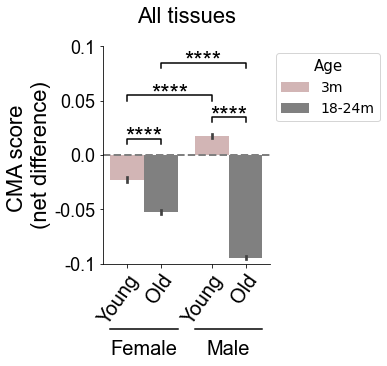

In [16]:
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='net_score', data=barcode, 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], 
            palette=['#D7B0B0', '#808080'], errorbar=('se'))

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.10, 0.10)
ax.set_yticks([-0.10, -0.05, 0.0, 0.05, 0.10])
ax.set_yticklabels([-0.10, -0.05, 0.0, 0.05, 0.10], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "15", fontsize = 14)
plt.title(label='All tissues', fontdict={'family':'Arial', 'size': 22}, y=1.08) 

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

# statistical annotation
x1, x2 = -0.2, 0.2   
y, h, col = 0.01 , 0.005, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-h, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

x1, x2 = 0.8, 1.2   
y, h, col = 0.03 , 0.005, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-h, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

x1, x2 = -.2, 0.8   
y, h, col = 0.05, 0.005, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-h, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

x1, x2 = 0.2, 1.2   
y, h, col = 0.08 , 0.005, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-h, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})


plt.savefig('../Khawaja_et_al_outputs/newAllTis/All_nsc_sex.png',bbox_inches='tight', dpi=600)

plt.show()

In [25]:
# Calculating n of mice per tissue, sex and age
for i in barcode.donor_id.unique():
    #print(i.title() + " length:" + str(len(barcode[barcode["new_cell"]==i].index)))
    print(i.title())
    print(barcode[barcode["donor_id"]==i].value_counts(["tissue"]))
    print("\n")

18_53_M
tissue                     
brain                          1235
bone marrow                    1221
heart                           699
large intestine                 564
lung                            372
liver                           372
spleen                          349
thymus                          335
mesenteric fat pad              271
subcutaneous adipose tissue     257
bladder lumen                   251
limb muscle                     226
tongue                          221
skin of body                    214
brown adipose tissue            158
kidney                          125
trachea                         115
aorta                            29
mammary gland                     0
pancreas                          0
diaphragm                         0
gonadal fat pad                   0
dtype: int64


18_45_M
tissue                     
brain                          1842
bone marrow                    1012
large intestine                 625
lung         

## L2 levels

In [29]:
# Selecting only L2 and L1 from adata
adata_lys = adata[:, 'ENSMUSG00000016534']

# Calculating the Z score for L2 & L1
lys_zs = adata_lys.copy().X.todense()

for i in tqdm(np.arange(lys_zs.shape[1])):
    
    µ = np.mean(lys_zs[:, i])
    sd = np.std(lys_zs[:, i])
    
    lys_zs[:, i] = (lys_zs[:, i] - µ)/sd
    print('New Zs done')
    
for i in tqdm(np.arange(lys_zs.shape[1])):
    
    µ2 = np.mean(lys_zs[:, i])
    sd2 = np.std(lys_zs[:, i])
    print('Mean {}'.format(µ2))
    print('SD {}'.format(sd2))

barcode['L2_Zs'] = lys_zs

barcode.head()

100%|██████████| 1/1 [00:00<00:00, 12.76it/s]


New Zs done


100%|██████████| 1/1 [00:00<00:00, 111.16it/s]


Mean 5.617543052949259e-08
SD 0.9999999403953552


,FACS.selection,age,cell,free_annotation,method,donor_id,subtissue,n_genes,n_counts,louvain,...,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,score,new_age,net_score,L2_Zs
index,,,,,,,,,,,,,,,,,,,,,
A10_B000497_B009023_S10.mm10-plus-0-0,Multiple,18m,A10_B000497,nan,facs,18_53_M,nan,2706,4855.988770,10,...,normal,Mus musculus,male,skin of body,na,18 month-old stage,0.840635,18-24m,0.792962,1.023220
A10_B000756_B007446_S10.mm10-plus-0-0,Viable,18m,A10_B000756,pancreatic B cell,facs,18_45_M,Endocrine,3212,6891.192383,31,...,normal,Mus musculus,male,pancreas,na,18 month-old stage,-0.152484,18-24m,-0.200157,0.798330
A10_B000802_B009022_S10.mm10-plus-0-0,Multiple,18m,A10_B000802,outer bulge,facs,18_47_F,Skin Anagen,2243,4707.827148,10,...,normal,Mus musculus,female,skin of body,na,18 month-old stage,-0.273630,18-24m,-0.321303,1.077763
A10_B000927_B007456_S10.mm10-plus-0-0,"CD31+, CD45+, CD31-CD45-Sca1+, CD31-CD45-Sca1-...",18m,A10_B000927,nan,facs,18_46_F,Muscle Diaphragm,2789,2543.752930,12,...,normal,Mus musculus,female,limb muscle,na,18 month-old stage,-0.136029,18-24m,-0.183702,-0.269622
A10_B001361_B007505_S10.mm10-plus-0-0,Viable,18m,A10_B001361,B cell,facs,18_46_F,RV,1237,3588.732910,1,...,normal,Mus musculus,female,heart,na,18 month-old stage,0.027133,18-24m,-0.020540,-1.156812


In [32]:
tis = ['brown adipose tissue', 'subcutaneous adipose tissue', 'brain', 'heart', 'kidney', 'liver', 'lung', 'limb muscle', 'pancreas']

In [35]:
colores = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a', '#66a61e', '#e6ab02', '#a6761d', '#e41a1c', '#666666']

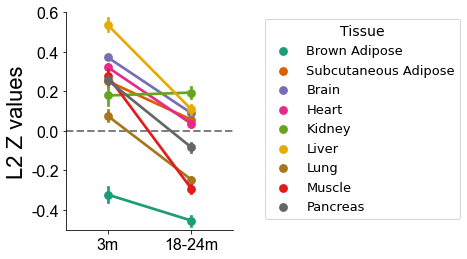

In [42]:
# CMA net score by tissues of interest
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.pointplot(x='new_age', y='L2_Zs', data=barcode, hue='tissue', 
              order=['3m', '18-24m'], hue_order=tis, palette= colores, errorbar=('se'))
plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.ylabel('L2 Z values', fontdict={'family':'Arial', 'size': 22})
ax.set_xticklabels(['3m', '18-24m'], fontdict={'family':'Arial', 'size': 16})
plt.xlabel('')
plt.ylim(-0.5, 0.60) 
ax.set_yticks([-0.4, -0.2, 0.0, 0.20, 0.40, 0.60])
ax.set_yticklabels([-0.4, -0.2, 0.0, 0.20, 0.40, 0.60], fontdict={'family':'Arial', 'size': 16})

# Legend
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['Brown Adipose', 'Subcutaneous Adipose', 'Brain', 'Heart', 'Kidney', 'Liver', 'Lung', 'Muscle', 'Pancreas'], 
          bbox_to_anchor=(1.15, 1), title="Tissue", title_fontsize = "14", fontsize=13) 

plt.savefig('../Khawaja_et_al_outputs/newAllTis/All_tiss_l2.png',bbox_inches='tight', dpi=600)

plt.show()

In [47]:
# 2-way Anova for all cells
model = ols('L2_Zs ~ C(new_age) + C(sex) + C(new_age):C(sex)',data=barcode).fit()
result = sm.stats.anova_lm(model, type=2)
print('2-way Anova\n')
print(result)
print('\n')

# Post hocs multi comparissons Bonferroni
interaction_groups = barcode.new_age.astype(str) + " & " + barcode.sex.astype(str)
comp = mc.MultiComparison(barcode['L2_Zs'], interaction_groups)
tbl, a1, a2 = comp.allpairtest(stats.ttest_ind, method= "bonf")
print('Post-Hoc Bonferroni\n')
print(tbl)
print('\n')

2-way Anova

                         df         sum_sq      mean_sq            F  \
C(new_age)              1.0    2293.218453  2293.218453  2345.568901   
C(sex)                  1.0      77.743652    77.743652    79.518413   
C(new_age):C(sex)       1.0     344.038362   344.038362   351.892199   
Residual           110092.0  107634.870945     0.977681          NaN   

                         PR(>F)  
C(new_age)         0.000000e+00  
C(sex)             4.848322e-19  
C(new_age):C(sex)  2.175917e-78  
Residual                    NaN  


Post-Hoc Bonferroni

Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.01, alphacBonf=0.005
     group1         group2      stat   pval pval_corr reject
------------------------------------------------------------
18-24m & female 18-24m & male  18.6975  0.0       0.0   True
18-24m & female   3m & female -13.7184  0.0       0.0   True
18-24m & female     3m & male -22.9538  0.0       0.0   True
18-24m & female  nan & female -13.1

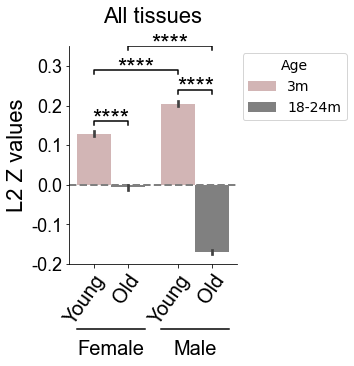

In [63]:
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='L2_Zs', data=barcode, 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], 
            palette=['#D7B0B0', '#808080'], errorbar=('se'))

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('L2 Z values', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.20, 0.35)
ax.set_yticks([-0.20, -0.10, 0.0, 0.10, 0.20, 0.30])
ax.set_yticklabels([-0.20, -0.10, 0.0, 0.10, 0.20, 0.30], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='All tissues', fontdict={'family':'Arial', 'size': 22}, y=1.08) 

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

# statistical annotation
x1, x2 = -0.2, 0.2   
y, h, col = 0.15 , 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-0.015, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

x1, x2 = 0.8, 1.2   
y, h, col = 0.23 , 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-0.015, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

x1, x2 = -.2, 0.8   
y, h, col = 0.28 , 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-0.015, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

x1, x2 = 0.2, 1.2   
y, h, col = 0.34 , 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-0.015, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

plt.savefig('../Khawaja_et_al_outputs/newAllTis/All_sex_l2.png',bbox_inches='tight', dpi=600)

plt.show()

## MA score vs CMA score

In [64]:
# Load matrix file with weight and direction 
model_matrix = pd.read_excel('../Exp. 2_Tabula muris/MA_model.xlsx')

# Removing ATG9B, HTT, PRKAA1, PRKAA2 and VPS11 genes because they don't appear in the adata
model_matrix = model_matrix.drop([8, 37, 43, 44, 58], axis=0).reset_index(drop=True)

# Finding MA network genes in the dataset
ma_network = adata[:, model_matrix["Ms_ENSM"]]

# Calculating the Zs scores
ma_data_zs = ma_network.copy().X.todense().T

for i in tqdm(np.arange(ma_data_zs.shape[0])):
    
    µ = np.mean(ma_data_zs[i, :])
    sd = np.std(ma_data_zs[i, :])
    
    ma_data_zs[i, :] = (ma_data_zs[i, :] - µ)/sd

# New column in barcode (aka adata.obs) with the CMA scores for each cell detected
for i,j in tqdm(enumerate(barcode.index)):
        
    cell_matrix = model_matrix.copy()

    for g in cell_matrix.index:

        cell_matrix.loc[g, 'gene_count'] = ma_data_zs[g, i]

    cell_matrix['gene_score'] = cell_matrix['gene_count'] * cell_matrix['Direction'] * cell_matrix['Weight']
    score = cell_matrix['gene_score'].sum()/np.sum(cell_matrix['Weight'])

    barcode.loc[j, 'ma_score'] = score   
    

100%|██████████| 74/74 [00:00<00:00, 82.87it/s]
110824it [18:51, 97.92it/s] 


In [65]:
# Calculation of net score to 3m using whole tissue CMA score mean
µ = np.mean(barcode[barcode['new_age'] == '3m']['ma_score'])

for i in tqdm(barcode.index):
    barcode.loc[i, 'ma_nscore'] = barcode.loc[i, 'ma_score'] - µ 

100%|██████████| 110824/110824 [00:20<00:00, 5518.22it/s]


In [66]:
barcode.head()

,FACS.selection,age,cell,free_annotation,method,donor_id,subtissue,n_genes,n_counts,louvain,...,sex,tissue,self_reported_ethnicity,development_stage,score,new_age,net_score,L2_Zs,ma_score,ma_nscore
index,,,,,,,,,,,,,,,,,,,,,
A10_B000497_B009023_S10.mm10-plus-0-0,Multiple,18m,A10_B000497,nan,facs,18_53_M,nan,2706,4855.988770,10,...,male,skin of body,na,18 month-old stage,0.840635,18-24m,0.792962,1.023220,0.032216,-0.019640
A10_B000756_B007446_S10.mm10-plus-0-0,Viable,18m,A10_B000756,pancreatic B cell,facs,18_45_M,Endocrine,3212,6891.192383,31,...,male,pancreas,na,18 month-old stage,-0.152484,18-24m,-0.200157,0.798330,-0.035205,-0.087061
A10_B000802_B009022_S10.mm10-plus-0-0,Multiple,18m,A10_B000802,outer bulge,facs,18_47_F,Skin Anagen,2243,4707.827148,10,...,female,skin of body,na,18 month-old stage,-0.273630,18-24m,-0.321303,1.077763,-0.125189,-0.177045
A10_B000927_B007456_S10.mm10-plus-0-0,"CD31+, CD45+, CD31-CD45-Sca1+, CD31-CD45-Sca1-...",18m,A10_B000927,nan,facs,18_46_F,Muscle Diaphragm,2789,2543.752930,12,...,female,limb muscle,na,18 month-old stage,-0.136029,18-24m,-0.183702,-0.269622,0.018573,-0.033283
A10_B001361_B007505_S10.mm10-plus-0-0,Viable,18m,A10_B001361,B cell,facs,18_46_F,RV,1237,3588.732910,1,...,female,heart,na,18 month-old stage,0.027133,18-24m,-0.020540,-1.156812,0.089467,0.037611


In [67]:
r, p = stats.pearsonr(x=barcode[barcode.sex=='female']['net_score'], y=barcode[barcode.sex=='female']['ma_nscore'])
r2, p2 = stats.pearsonr(x=barcode[barcode.sex=='male']['net_score'], y=barcode[barcode.sex=='male']['ma_nscore'])

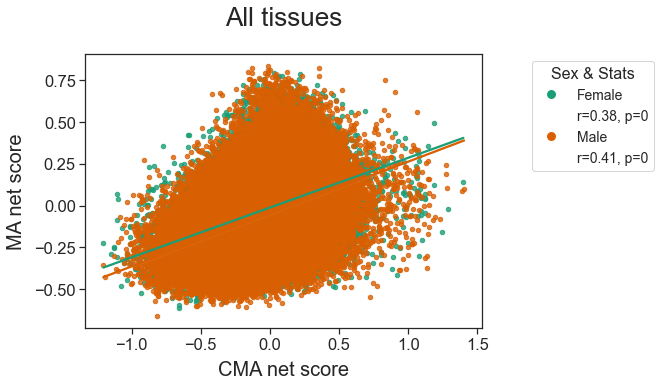

In [70]:
sns.set(font_scale=1.5)
sns.set_style('ticks', rc={'xtick.labelsize':14, 'ytick.labelsize':14})
lm = sns.lmplot(data=barcode, x="net_score", y="ma_nscore", ci=68, scatter_kws={"s": 20},
                hue='sex', hue_order=['female', 'male'], palette= 'Dark2', legend=False)
fig = lm.fig
fig.set_size_inches(8, 5)
a1 = fig.axes[0]
a1.set_ylabel("MA net score", size = 20, labelpad=8)
a1.set_xlabel("CMA net score", size = 20, labelpad=8)
sns.despine(top=False, right=False, left=False, bottom=False)
labels = ['Female', 'r={:.2f}, p={:.2g}'.format(r, p), 'Male', 'r={:.2f}, p={:.2g}'.format(r2, p2)]
handles = [Line2D([0], [0], marker='o', color='w', label='Scatter', markerfacecolor='#1b9e77', markersize=10),
           Line2D([0], [0], marker='o', color='w', label='Scatter', markerfacecolor='w', markersize=2),
           Line2D([0], [0], marker='o', color='w', label='Scatter', markerfacecolor='#d95f02', markersize=10),
           Line2D([0], [0], marker='o', color='w', label='Scatter', markerfacecolor='w', markersize=2)]
a1.legend(handles, labels, bbox_to_anchor=(1.45, 1), title="Sex & Stats", title_fontsize = "16", fontsize=14) 
plt.title(label='All tissues', fontdict={'family':'Arial', 'size': 26}, y=1.08)
plt.savefig('../Khawaja_et_al_outputs/newAllTis/CMAvsMA_ns.png',bbox_inches='tight', dpi=600)
plt.show()

In [75]:
# 2-way Anova for all cells
model = ols('ma_nscore ~ C(new_age) + C(sex) + C(new_age):C(sex)',data=barcode).fit()
result = sm.stats.anova_lm(model, type=2)
print('2-way Anova\n')
print(result)
print('\n')

# Post hocs multi comparissons Bonferroni
interaction_groups = barcode.new_age.astype(str) + " & " + barcode.sex.astype(str)
comp = mc.MultiComparison(barcode['ma_nscore'], interaction_groups)
tbl, a1, a2 = comp.allpairtest(stats.ttest_ind, method= "bonf")
print('Post-Hoc Bonferroni\n')
print(tbl)
print('\n')

2-way Anova

                         df       sum_sq     mean_sq            F  \
C(new_age)              1.0   206.746813  206.746813  4687.187059   
C(sex)                  1.0    24.687973   24.687973   559.704614   
C(new_age):C(sex)       1.0    76.980650   76.980650  1745.239518   
Residual           110092.0  4856.040497    0.044109          NaN   

                          PR(>F)  
C(new_age)          0.000000e+00  
C(sex)             1.985551e-123  
C(new_age):C(sex)   0.000000e+00  
Residual                     NaN  


Post-Hoc Bonferroni

Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.01, alphacBonf=0.005
     group1         group2      stat   pval pval_corr reject
------------------------------------------------------------
18-24m & female 18-24m & male  46.5389  0.0       0.0   True
18-24m & female   3m & female  -5.8527  0.0       0.0   True
18-24m & female     3m & male -21.0268  0.0       0.0   True
18-24m & female  nan & female -11.2478  0.0  

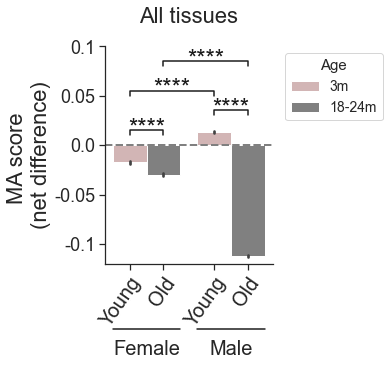

In [77]:
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='ma_nscore', data=barcode, 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], 
            palette=['#D7B0B0', '#808080'], errorbar=('se'))

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('MA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.12, 0.05)
ax.set_yticks([-0.10, -0.05, 0.0, 0.05, 0.10])
ax.set_yticklabels([-0.10, -0.05, 0.0, 0.05, 0.10], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "15", fontsize = 14)
plt.title(label='All tissues', fontdict={'family':'Arial', 'size': 22}, y=1.08) 

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

# statistical annotation
x1, x2 = -0.2, 0.2   
y, h, col = 0.01 , 0.005, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-h, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

x1, x2 = 0.8, 1.2   
y, h, col = 0.03 , 0.005, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-h, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

x1, x2 = -.2, 0.8   
y, h, col = 0.05, 0.005, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-h, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

x1, x2 = 0.2, 1.2   
y, h, col = 0.08 , 0.005, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-h, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})


plt.savefig('../Khawaja_et_al_outputs/newAllTis/All_mansc_sex.png',bbox_inches='tight', dpi=600)

plt.show()